In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.datasets import load_breast_cancer

wdbc=load_breast_cancer()
print(wdbc.DESCR)
print('특징 이름=',list(wdbc.feature_names))
print('부류 이름=',list(wdbc.target_names))

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
결정 트리의 정확률= 0.9824253075571178


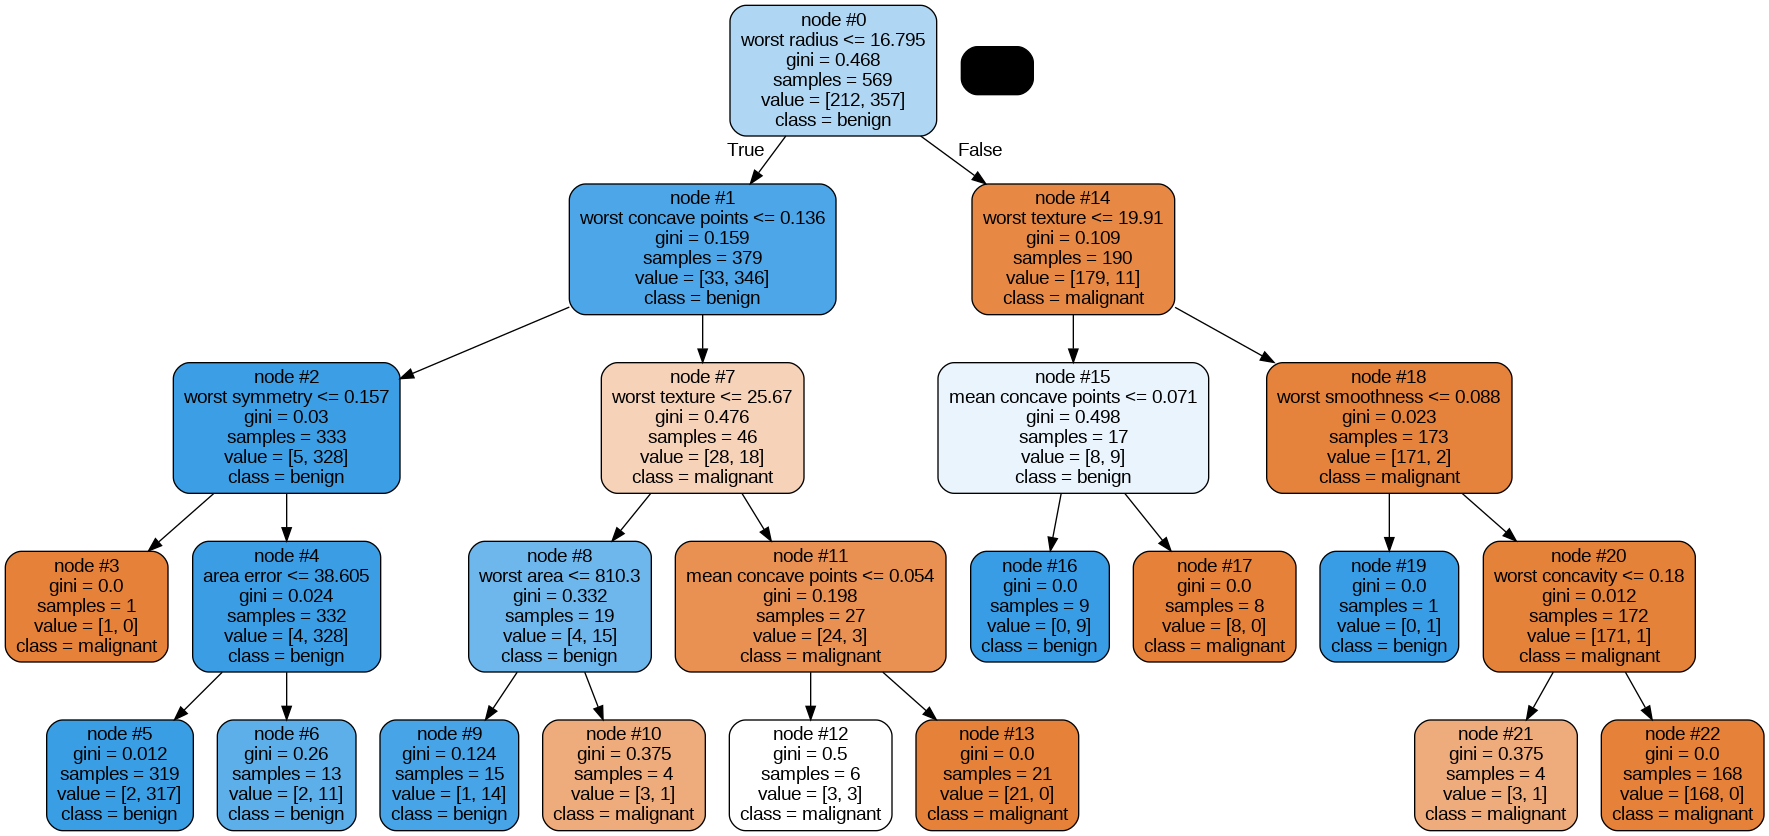

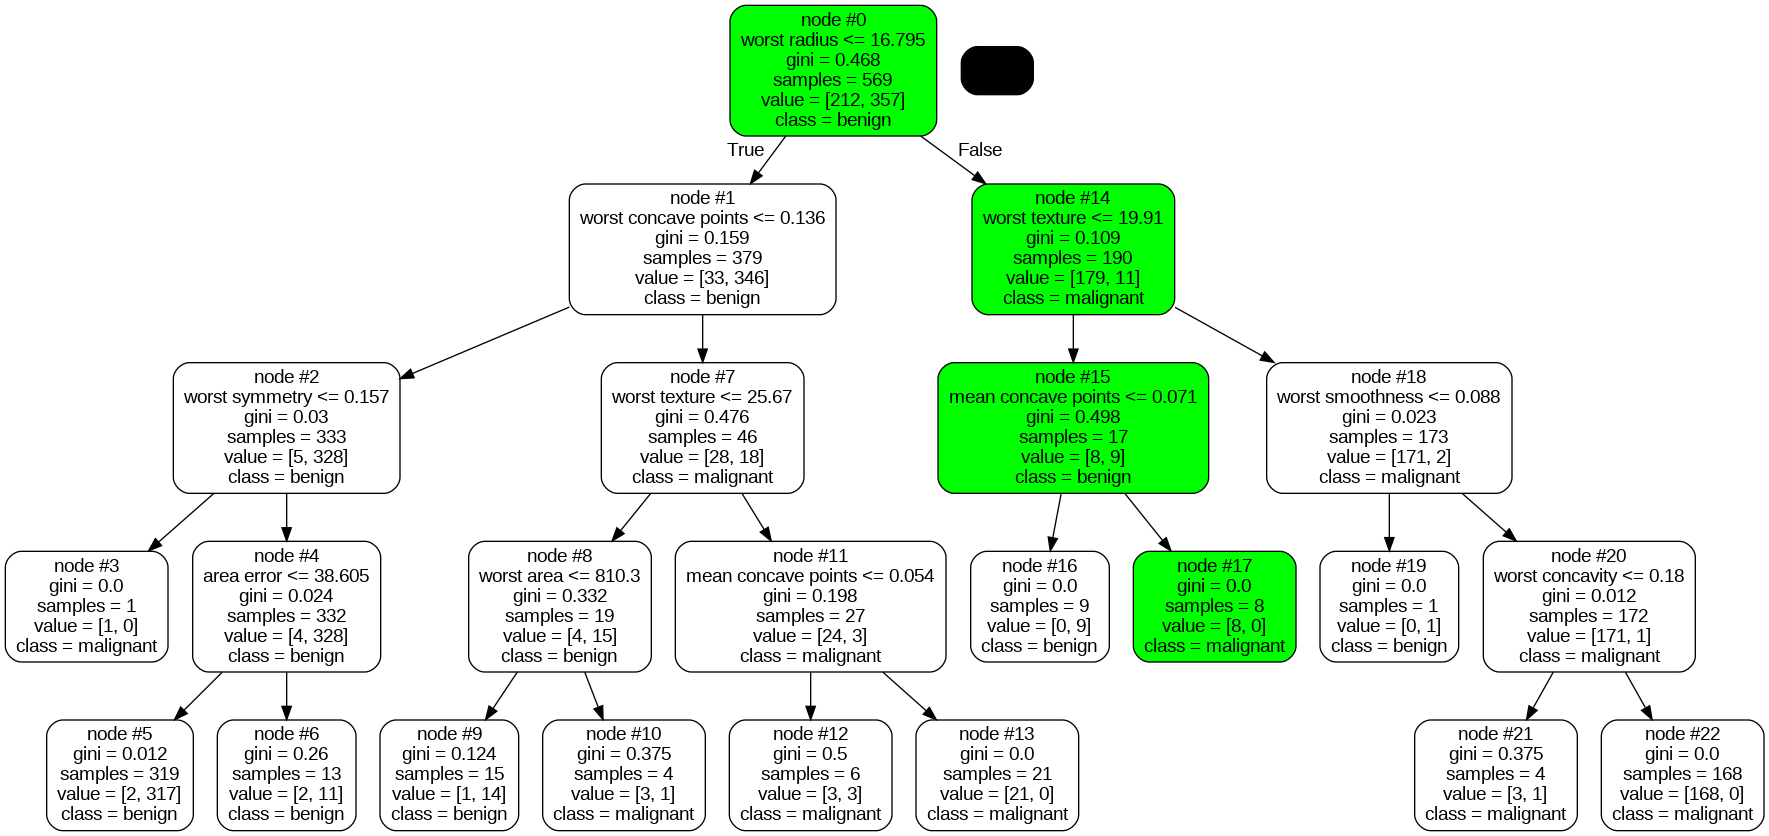

In [ ]:
!apt-get install graphviz
!pip install pydotplus

from sklearn.datasets import load_breast_cancer
from sklearn import tree
import pydotplus
from IPython.display import Image, display

wdbc = load_breast_cancer()

decision_tree = tree.DecisionTreeClassifier(max_depth=4, random_state=1)
dt = decision_tree.fit(wdbc.data, wdbc.target)  # 결정 트리 학습

res = dt.predict(wdbc.data)
print('결정 트리의 정확률=', sum(res == wdbc.target) / len(res))  # 예측

dot = tree.export_graphviz(dt, out_file=None, feature_names=wdbc.feature_names, class_names=wdbc.target_names, filled=True, node_ids=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot)

graph.write_png('tree.png')  # 결정 트리를 위한 그림 저장
display(Image('tree.png'))

x_test = wdbc.data[0:1]
path = dt.decision_path(x_test)
path_seq = path.toarray()[0]

for n, value in enumerate(path_seq):
    node = graph.get_node(str(n))[0]
    if value == 0:
        node.set_fillcolor('white')
    else:
        node.set_fillcolor('green')  # 의사결정 경로를 green 색으로 표시

graph.write_png('tree_with_path.png')  # 의사결정 경로를 포함한 그림 저장
display(Image('tree_with_path.png'))

102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

<ipython-input-5-18dc7c458317>:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet=cm.get_cmap("jet") # [0,255] 열지도를 jet 컬러맵으로 표시함


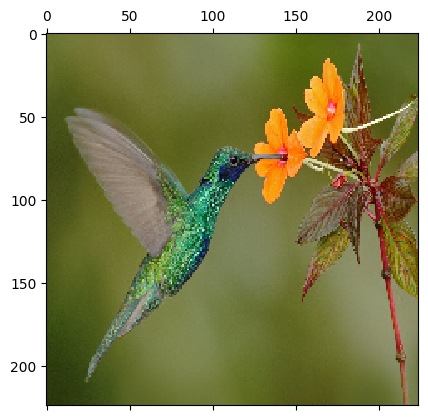

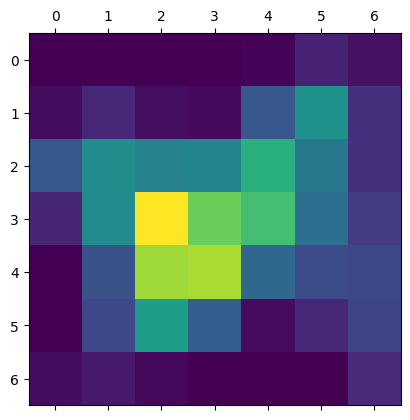

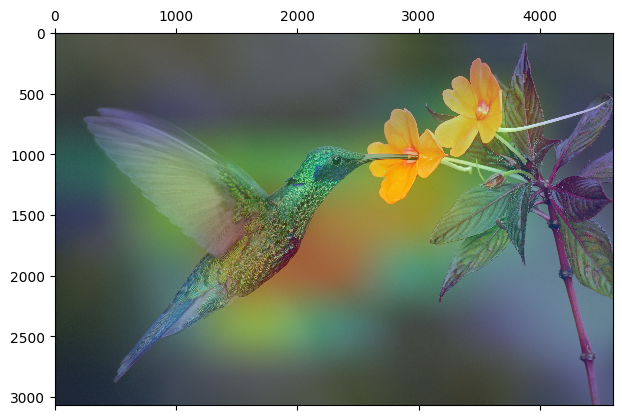

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50,ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 사전 학습된 신경망 모델을 불러오고 신경망 구조를 확인
model=ResNet50(weights='imagenet')
model.summary()

# 지정된 영상을 불러와 크기 조정하고 화면에 디스플레이
image_path='/content/drive/MyDrive/CodeData/GitHub_Examples/XAI_DT_CAM_hummingbird.jpg'
img=image.load_img(image_path,target_size=(224,224))
plt.matshow(img)

# 영상을 신경망 입력 형태로 변환
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=resnet50.preprocess_input(x)

# 인식을 시도하고 top-5 결과를 출력
preds=model.predict(x)
print("예측 결과:", resnet50.decode_predictions(preds,top=5)[0])

# 신경망 모델의 특징 추출(컨볼루션층) 부분에서 마지막 층을 지정
# 특징 추출 부분만으로 구성된 모델 model_1 만들기
last_conv_layer=model.get_layer("conv5_block3_out")

model_1=keras.Model(model.inputs,last_conv_layer.output)

# 분류(전역평균 풀링 또는 완전연결층) 부분만으로 구성된 모델 model_2 만들기
input_2=keras.Input(shape=last_conv_layer.output.shape[1:])
x_2=model.get_layer("avg_pool")(input_2)
x_2=model.get_layer("predictions")(x_2) 
model_2=keras.Model(input_2,x_2)

# GradientTape 함수를 이용한 그레이디언트 계산
with tf.GradientTape() as tape:
    output_1=model_1(x)
    tape.watch(output_1) # 마지막 층으로 미분하기 위한 준비
    preds=model_2(output_1)
    class_id=tf.argmax(preds[0])
    output_2=preds[:,class_id]

grads=tape.gradient(output_2,output_1) # 그레이디언트 계산
pooled_grads=tf.reduce_mean(grads,axis=(0,1,2))

output_1=output_1.numpy()[0]
pooled_grads=pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i]*=pooled_grads[i]
heatmap=np.mean(output_1,axis=-1)

heatmap=np.maximum(heatmap,0)/np.max(heatmap) # [0,1]로 정규화
plt.matshow(heatmap)

# 열지도를 입력 영상에 덧씌움
img=image.load_img(image_path) # 입력 영상을 다시 받아옴

img=image.img_to_array(img)
heatmap=np.uint8(255*heatmap) # [0,255]로 변환

jet=cm.get_cmap("jet") # [0,255] 열지도를 jet 컬러맵으로 표시함
color=jet(np.arange(256))[:,:3]
color_heatmap=color[heatmap]

color_heatmap=keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap=color_heatmap.resize((img.shape[1],img.shape[0]))
color_heatmap=keras.preprocessing.image.img_to_array(color_heatmap)

overlay_img=color_heatmap*0.4+img # 덧씌움
overlay_img=keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)

91884032/91884032 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

<ipython-input-6-b92c9ec8a88b>:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet=cm.get_cmap("jet") # [0,255] 열지도를 jet 컬러맵으로 표시함


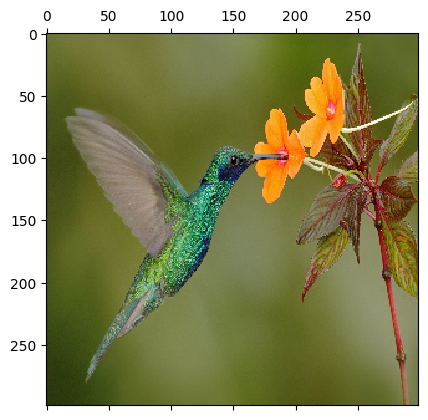

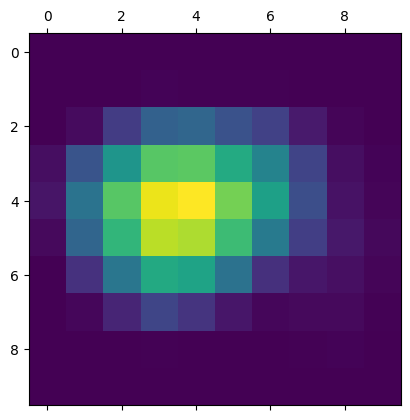

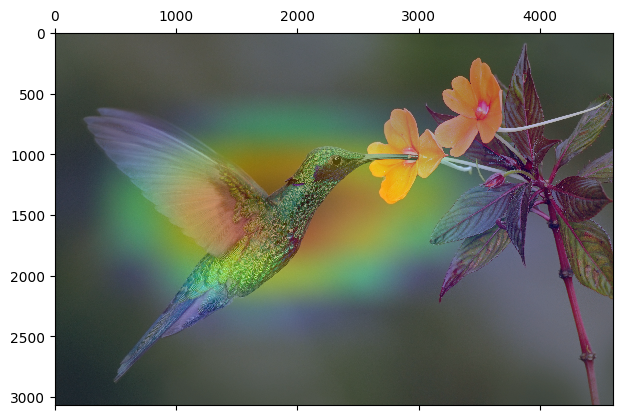

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 사전 학습된 신경망 모델을 불러오고 신경망 구조를 확인
model=xception.Xception(weights='imagenet')
model.summary()

# 지정된 영상을 불러와 크기를 조정하고 화면에 디스플레이
image_path='/content/drive/MyDrive/CodeData/GitHub_Examples/XAI_DT_CAM_hummingbird.jpg'
img=image.load_img(image_path,target_size=(299,299))
plt.matshow(img)

# 영상을 신경망 입력 형태로 변환
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=xception.preprocess_input(x)

# 인식을 시도하고 top-5 결과를 출력
preds = model.predict(x)
print("예측 결과:", xception.decode_predictions(preds,top=5)[0])

# 신경망 모델의 특징 추출(컨볼루션층) 부분에서 마지막 층을 지정
# 특징 추출 부분만으로 구성된 모델 model_1 만들기
last_conv_layer=model.get_layer("block14_sepconv2_act")

model_1=keras.Model(model.inputs,last_conv_layer.output)

# 분류(전역평균 풀링 또는 완전연결 층) 부분만으로 구성된 모델 model_2 만들기
input_2=keras.Input(shape=last_conv_layer.output.shape[1:])
x_2=model.get_layer("avg_pool")(input_2)
x_2=model.get_layer("predictions")(x_2)
model_2=keras.Model(input_2,x_2)

# GradientTape 함수를 이용한 그레이디언트 계산
with tf.GradientTape() as tape:
    output_1=model_1(x)
    tape.watch(output_1) # 마지막 층으로 미분하기 위한 준비
    preds=model_2(output_1)
    class_id=tf.argmax(preds[0])
    output_2=preds[:,class_id]

grads=tape.gradient(output_2,output_1) # 그레이디언트 계산
pooled_grads=tf.reduce_mean(grads,axis=(0,1,2))

output_1=output_1.numpy()[0]
pooled_grads=pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i]*=pooled_grads[i]
heatmap=np.mean(output_1,axis=-1)

heatmap=np.maximum(heatmap,0)/np.max(heatmap) # [0,1]로 정규화
plt.matshow(heatmap)

# 열지도를 입력 영상에 덧씌움
img=image.load_img(image_path) # 입력 영상을 다시 받아옴

img=image.img_to_array(img)
heatmap=np.uint8(255*heatmap) # [0,255]로 변환

jet=cm.get_cmap("jet") # [0,255] 열지도를 jet 컬러맵으로 표시함
color=jet(np.arange(256))[:,:3]
color_heatmap=color[heatmap]

color_heatmap=keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap=color_heatmap.resize((img.shape[1],img.shape[0]))
color_heatmap=keras.preprocessing.image.img_to_array(color_heatmap)

overlay_img=color_heatmap*0.4+img # 덧씌움
overlay_img=keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)